# Executive Summary

This project looks at data on taxi journeys in New York city to attempt to predict the fare for such trips.

# 1. Import Data

Due to the scale of the data (and computational limits), I will only consider a portion of the training data in my analysis.

There are c. 55 million taxi trips in the training set. My samplying will consider 5% of such journeys (i.e. c. 2.75m trips). A randomised sample will be taken to avoid any issues with bias that may come with e.g. taking the first 2.75m million rows of the data.

In [2]:
#Importing relevant packages and modules
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sample_data_percentage = 0.05  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.05 the row will be skipped
analysis_data = pd.read_csv(
         'train.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > sample_data_percentage
)

analysis_data.head()

key  ...  passenger_count
0    2011-01-06 09:50:45.0000002  ...                1
1   2010-07-07 14:52:00.00000044  ...                1
2  2009-01-09 16:10:00.000000170  ...                3
3   2013-09-07 03:17:00.00000014  ...                1
4   2012-01-02 14:54:00.00000078  ...                1

[5 rows x 8 columns]

As shown above, the features included in the data are:

- key - A unique identifier of each trip
- fare_amount, the measure to be predicted in the test set
- pickup_datetime, which appears to contain slightly differently formatted but equivalent data to the key
- pickup_longitude and pickup_latitude , which describe the location of the start of the journey
- dropoff_longitude and dropoff_latitude , which describe the location of the end of the journey
- passenger_count


# 2. Exploratory Data Analysis

## 2.1 Missing Values

First, we check the data for any features which contain missing values.

In [4]:
missing_data = analysis_data.isnull().sum()
missing_data.head()

key                 0
fare_amount         0
pickup_datetime     0
pickup_longitude    0
pickup_latitude     0
dtype: int64

There is no missing data.

## 2.2. Exploration of Original Features

Now, moving onto conducting an analysis of the original, firstly checking the datatype of each feature, then moving onto whether there may be any values that are incorrect or extreme and should potentially be removed prior to applying any MLAs.

In [5]:
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772108 entries, 0 to 2772107
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 169.2+ MB


The key feature should be converted to datetime and used as the pickup_time feature.

In [0]:
analysis_data['pickup_datetime'] = pd.to_datetime(analysis_data['key'])

In [7]:
#Use describe method to give summary of metrics of data
analysis_data.describe()

fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  2.772108e+06      2.772108e+06  ...      2.772088e+06     2.772108e+06
mean   1.134276e+01     -7.251654e+01  ...      3.992570e+01     1.684661e+00
std    9.791433e+00      1.270270e+01  ...      9.278932e+00     1.344781e+00
min   -8.975000e+01     -3.348354e+03  ...     -3.240599e+03     0.000000e+00
25%    6.000000e+00     -7.399208e+01  ...      4.073404e+01     1.000000e+00
50%    8.500000e+00     -7.398181e+01  ...      4.075318e+01     1.000000e+00
75%    1.250000e+01     -7.396708e+01  ...      4.076811e+01     2.000000e+00
max    5.000000e+02      3.061873e+03  ...      3.305291e+03     2.080000e+02

[8 rows x 6 columns]

Some key intial takeaways from this, to be explored in more detail:

- fare_amount
  - There are some negative values for fare_amount - logically this does not make sense, hence these values should be excluded
  - The majority of trips were up to c. \$13, however there are some very high fare amount trips (up to c. \$2,000). This should be explored further before making any decision on what to do 

- Location
  - By definition, latitude ranges between -90 and + 90. However the data here is showing some incorrect values that fall outside of this range. Similarly, longitude ranges between -180 and + 180, and some of the values displayed are outside of this rage
  - For each of the pickup/dropoff longitude/latitude the 25th centile, median value, and 75th centile are all the same value. This seems slightly strange as it implied that at least half of all the trips had the same pickup and drop off location

- passenger_count
  - There are some trips with zero passengers. This may imply that e.g. the taxi is acting as a courier service, or is potentially an error
  - Most trips has one to two passengers
  - The greatest number of passenger listed is 208. This appears to be an error (or a very large taxi)


Now, moving onto explore each of the original features in more detail.

### 2.2.1 fare_amount

Firstly, dropping the negative fare_amount trips from the dataset.

In [0]:
#Drop any trips with (an incorrect) negative fare_amount
analysis_data = analysis_data[analysis_data['fare_amount']>0]

Next, we plot a histogram to better observe the data

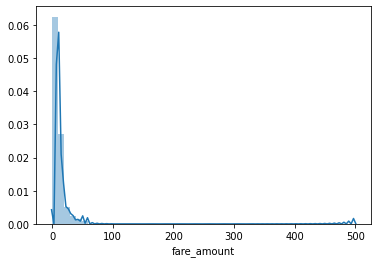

In [9]:
ax = sns.distplot(analysis_data['fare_amount'])

The plot demonstrates that the vast majority of datapoints are well under the maximum fare_amount. More formally, let's find the 99.9th percentile of fare_amount

In [10]:
#Calculate the 99th centile of the fare_amount
print("The 99th centile of fare_amount is "+ str(analysis_data['fare_amount'].quantile(0.99)))

The 99th centile of fare_amount is 53.0


Therefore, a decision is taken to drop any trips with a fare_amount of >500, as this may indicate an error or a very long specific trip. Of course, this 500 level is relatively arbitary, however only a very small number of journeys are excluded therefore the exact level is relatively unimportant.

In [0]:
analysis_data = analysis_data[analysis_data['fare_amount']<=500]

### 2.2.2 pickup_datetime
To explore this feature in greater detail, it is necessary to consider extracting new features (such as month, day of the week etc). This will be done in section 3.

### 2.2.3 Pickup/Dropoff Latitude and Longitude
It would be prudent to consider these features to together.

#### 2.2.3.1 Location Errors

On Earth, longitude ranges between -180° and +180°, and latitude similarly ranges between -90° and +90°. Therefore, first create a bounding box which includes all potential locations on earth, and exclude any trips which have either a pickup or dropoff location outside this box

In [0]:
#Define bounding box of the Earth
earth_BBox = [-180, +180, -90, +90]

#Exclude any trips that contain a location that is not correctly defined on Earth
analysis_data = analysis_data[analysis_data['pickup_longitude']>=earth_BBox[0]]
analysis_data = analysis_data[analysis_data['dropoff_longitude']>=earth_BBox[0]]

analysis_data = analysis_data[analysis_data['pickup_longitude']<=earth_BBox[1]]
analysis_data = analysis_data[analysis_data['dropoff_longitude']<=earth_BBox[1]]

analysis_data = analysis_data[analysis_data['pickup_latitude']>=earth_BBox[2]]
analysis_data = analysis_data[analysis_data['dropoff_latitude']>=earth_BBox[2]]

analysis_data = analysis_data[analysis_data['pickup_latitude']<=earth_BBox[3]]
analysis_data = analysis_data[analysis_data['dropoff_latitude']<=earth_BBox[3]]

#### 2.2.3.2 Location Analysis

The next thing to do is to map the data points of both the pickups and the dropoffs onto a map of NYC.

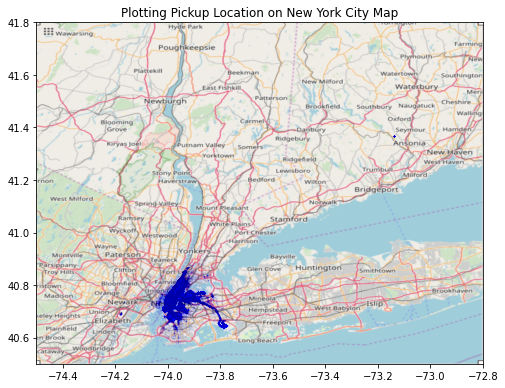

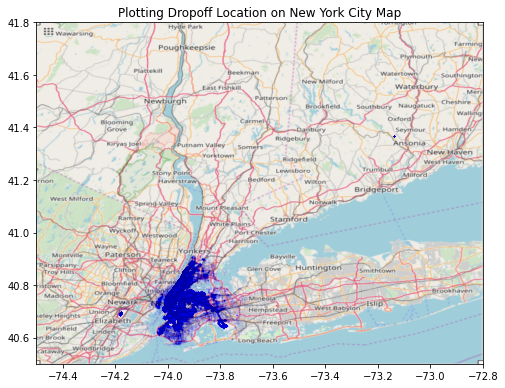

In [13]:
#Download a map of NYC and use it to define the plot bounding box
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
BB = (-74.5, -72.8, 40.5, 41.8)

#Plot the pickup locations
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(analysis_data['pickup_longitude'], analysis_data['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB[0],BB[1])
ax.set_ylim(BB[2],BB[3])
ax.imshow(nyc_map, zorder=0, extent = BB, aspect= 'equal')

#Plot the dropoff locations
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(analysis_data['dropoff_longitude'], analysis_data['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB[0],BB[1])
ax.set_ylim(BB[2],BB[3])
ax.imshow(nyc_map, zorder=0, extent = BB, aspect= 'equal')

Interestingly, the dropoff locations seem to be slightly more sparse than the pickup locations. This may suggest that taxis typically pickup passengers from a more narrow set of locations and do not e.g. typically begin journeys at passengers' homes.

It is also noticeable there are a few locations that are further out e.g. the spot at c. 40.7 latitude, -74.2 longitude.

It would be helpful to zoom in on this graph, therefore a smaller bounding box is defined, and the pickup and dropoff locations are plotted.

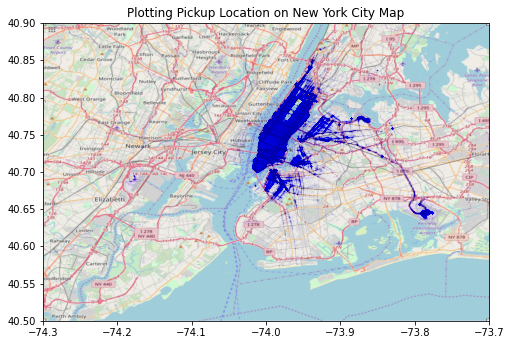

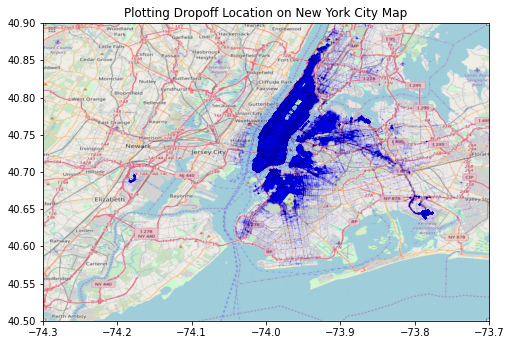

In [14]:
#Use smaller map
nyc_map_small = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')
BB_small = (-74.3, -73.7, 40.5, 40.9)

#Plot the pickup locations
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(analysis_data['pickup_longitude'], analysis_data['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the pickup locations
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(analysis_data['dropoff_longitude'], analysis_data['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

It is observed that most pickup and dropoff locations seem to be focussed on Manhattan and Brooklyn, with some activity in the South East of the city and an even lower amount of activity in the South West (to be explored later).

The purpose of this project is to predict the fare_amount for the submission data. Therefore, we are only interested in locations that are relevant to the submission data. A bounding box may be created (from the exrtemeties of the pickup and dropoff locations of the submission data), to then exclude the analysis data which has locations outside of this box.

In [15]:
#Read in the test data to assess the required boundary
submission_data = pd.read_csv("test.csv")
submission_data.head()

key  ... passenger_count
0  2015-01-27 13:08:24.0000002  ...               1
1  2015-01-27 13:08:24.0000003  ...               1
2  2011-10-08 11:53:44.0000002  ...               1
3  2012-12-01 21:12:12.0000002  ...               1
4  2012-12-01 21:12:12.0000003  ...               1

[5 rows x 7 columns]

Note the submission data has all the features of the analysis data, except for the fare_amount, which we are trying to predict.

In [0]:
#Find the extreme locations of the submission data and use this to create a bounding box to select only a subset of the analysis data
submission_data_min_pickup_longitude = min(submission_data["pickup_longitude"])
submission_data_max_pickup_longitude = max(submission_data["pickup_longitude"])

submission_data_min_pickup_latitude = min(submission_data["pickup_latitude"])
submission_data_max_pickup_latitude = max(submission_data["pickup_latitude"])

submission_data_min_dropoff_longitude = min(submission_data["dropoff_longitude"])
submission_data_max_dropoff_longitude = max(submission_data["dropoff_longitude"])

submission_data_min_dropoff_latitude = min(submission_data["dropoff_latitude"])
submission_data_max_dropoff_latitude = max(submission_data["dropoff_latitude"])

#Create a bounding box for the submission data, and use this for a bounding box for the analysis data
submission_data_bb = [min(submission_data_min_pickup_longitude,submission_data_min_dropoff_longitude), max(submission_data_max_pickup_longitude, submission_data_max_dropoff_longitude), min(submission_data_min_pickup_latitude,submission_data_min_dropoff_latitude), max(submission_data_max_pickup_latitude, submission_data_max_dropoff_latitude)]

#Exclude any trips that contain a location that is not correctly defined on Earth
analysis_data_subset = analysis_data[analysis_data['pickup_longitude']>=submission_data_bb[0]]
analysis_data_subset = analysis_data_subset[analysis_data_subset['dropoff_longitude']>=submission_data_bb[0]]

analysis_data_subset = analysis_data_subset[analysis_data_subset['pickup_longitude']<=submission_data_bb[1]]
analysis_data_subset = analysis_data_subset[analysis_data_subset['dropoff_longitude']<=submission_data_bb[1]]

analysis_data_subset = analysis_data_subset[analysis_data_subset['pickup_latitude']>=submission_data_bb[2]]
analysis_data_subset = analysis_data_subset[analysis_data_subset['dropoff_latitude']>=submission_data_bb[2]]

analysis_data_subset = analysis_data_subset[analysis_data_subset['pickup_latitude']<=submission_data_bb[3]]
analysis_data_subset = analysis_data_subset[analysis_data_subset['dropoff_latitude']<=submission_data_bb[3]]


In [17]:
analysis_data_subset.describe()

fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  2.712990e+06      2.712990e+06  ...      2.712990e+06     2.712990e+06
mean   1.131372e+01     -7.397510e+01  ...      4.075147e+01     1.684342e+00
std    9.626922e+00      3.837450e-02  ...      3.270973e-02     1.327594e+00
min    1.000000e-02     -7.426246e+01  ...      4.056950e+01     0.000000e+00
25%    6.000000e+00     -7.399229e+01  ...      4.073559e+01     1.000000e+00
50%    8.500000e+00     -7.398210e+01  ...      4.075389e+01     1.000000e+00
75%    1.250000e+01     -7.396830e+01  ...      4.076840e+01     2.000000e+00
max    5.000000e+02     -7.298875e+01  ...      4.159791e+01     2.080000e+02

[8 rows x 6 columns]

In [18]:
#Calculate the % of data excluded by this process
print("Using the submission data as a bounding box has excluded %.2f"% (100*(1 - len(analysis_data_subset)/(len(analysis_data)))) +"% of the data")

Using the submission data as a bounding box has excluded 2.12% of the data


### 2.2.4 passenger_count

(0.0, 100.0)

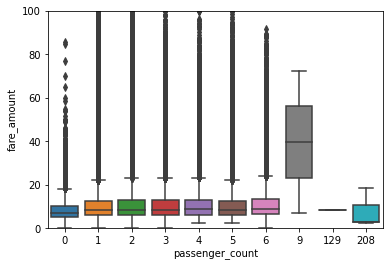

In [19]:
ax = sns.boxplot(x="passenger_count", y="fare_amount", data=analysis_data_subset)
ax.set_ylim(0,100)

The plot shows that a number of journeys have no passenger. It would be interesting to know exactly how many of the trips show zero passengers (as well as occurences for the other numbers of passengers).

In [20]:
#Check % of trips which have each number of passengers
100*analysis_data_subset["passenger_count"].value_counts()/len(analysis_data_subset["passenger_count"])

1      69.200071
2      14.728952
5       7.077099
3       4.403997
4       2.129164
6       2.105610
0       0.354885
208     0.000111
9       0.000074
129     0.000037
Name: passenger_count, dtype: float64

As shown. c. 70% of trips have 1 passenger, c. 15% have 2 passengers, and between 2% and 5% have 3 to 6 passengers.

Note that c. 0.35% of trips have zero passengers. It would be interesting to know if any of the trips in the submission data have zero passengers.

In [21]:
#Check % of trips which have each number of passengers for the submission data
100*submission_data["passenger_count"].value_counts()/len(submission_data["passenger_count"])

1    69.739762
2    14.867864
5     7.020375
3     4.508775
4     2.077870
6     1.785354
Name: passenger_count, dtype: float64

All trips in the submission data have 1 to 6 passengers, therefore we drop any trips with either 0 or 7+ passengers from our analysis data.

In [0]:
#Exclude any trips with 0 passengers
analysis_data_subset = analysis_data[analysis_data['passenger_count']>=1]

#Exclude any trips with 7+ passengers
analysis_data_subset = analysis_data[analysis_data['passenger_count']<=6]

## 2.3 Creation of New Features

As previously mentioned, the pickup_datetime is to be used to create new time based features to assess if there is any time based predictability to the trips.

### 2.3.1 Extract Day of Week of Pickup

A new feature of the weekday of the pickup is created. This will help assess whether there is any difference in cost of trips e.g. due to the weekend

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.0, 30.0)

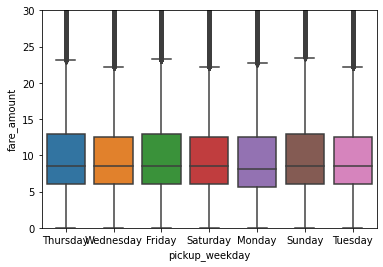

In [23]:
#Create a new feature of the pickup_weekday
analysis_data_subset["pickup_weekday"] = analysis_data_subset["pickup_datetime"].dt.day_name()

#Plot the pickup_weekday to observe the affect on fare_amount
ax = sns.boxplot(x="pickup_weekday", y="fare_amount", data=analysis_data_subset)
ax.set_ylim(0,30)

There does not appear to be a material difference between the fare amounts on different days.

### 2.3.2 Extract Hour of Day of Pickup
Similarly, extract the hour of the pickup - to assess whether e.g. trips beginning at night are more expensive.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.0, 30.0)

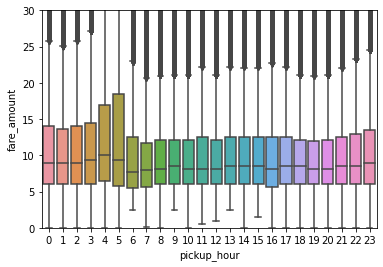

In [24]:
#Create a new feature of the pickup_hour
analysis_data_subset["pickup_hour"] = analysis_data_subset["pickup_datetime"].dt.hour

#Plot the pickup_hour to observe the affect on fare_amount
ax = sns.boxplot(x="pickup_hour", y="fare_amount", data=analysis_data_subset)
ax.set_ylim(0,30)

For trips with early hours pickup (i.e. 03:00 to 05:00) there seems to be some skew towards higher fare amounts.

### 2.3.3 Extract Month of Year of Pickup
There may be seasonality to the fare, therefore the month of the pickup is extracted.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.0, 30.0)

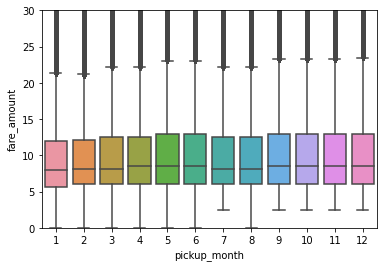

In [25]:
#Create a new feature of the pickup_month
analysis_data_subset["pickup_month"] = analysis_data_subset["pickup_datetime"].dt.month

#Plot the pickup_month to observe the affect on fare_amount
ax = sns.boxplot(x="pickup_month", y="fare_amount", data=analysis_data_subset)
ax.set_ylim(0,30)

There does not appear to be a material affect of the month of the trip on its fare.

### 2.3.4 Extract Year of Pickup

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.0, 30.0)

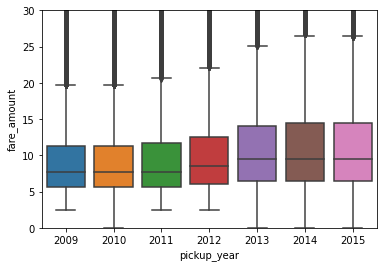

In [26]:
#Create a new feature of the pickup_year
analysis_data_subset["pickup_year"] = analysis_data_subset["pickup_datetime"].dt.year

#Plot the pickup_year to observe the affect on fare_amount
ax = sns.boxplot(x="pickup_year", y="fare_amount", data=analysis_data_subset)
ax.set_ylim(0,30)

The data shows a clear trend - fares have increased by year.

### 2.3.3 Longitude Traversed

It would be interesting to note if there was any relationship between the fare_amount, and the degrees of longitude through which the journey passed.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


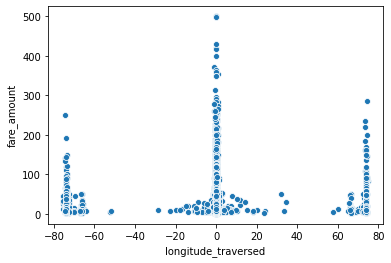

In [27]:
#Creation of longitude_traversed feature
analysis_data_subset["longitude_traversed"] = analysis_data_subset["dropoff_longitude"] - analysis_data_subset["pickup_longitude"]

#Plotting of longitude_traverse
ax = sns.scatterplot(x="longitude_traversed", y="fare_amount", data=analysis_data_subset)

There does not seem to be an obvious relationship between fare_amount and longitude_traversed noticeable by graph. We can more formally check this using the Pearson correlation coefficient.

In [28]:
#Calculate the correlation between fare_amount and the longitude_traversed
print("The correlation between fare_amount and longitude_traversed is %.2f"% analysis_data_subset["longitude_traversed"].corr(analysis_data_subset["fare_amount"]))

The correlation between fare_amount and longitude_traversed is 0.00


i.e. there is very little correlation betwen the fare_amount and the longitude_traversed.

### 2.3.3 Latitude Traversed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


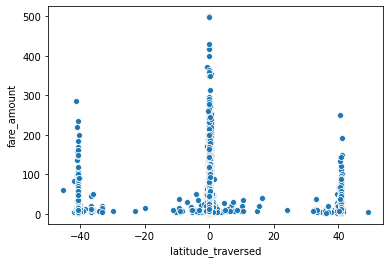

In [29]:
#Creation of latitude_traversed feature
analysis_data_subset["latitude_traversed"] = analysis_data_subset["dropoff_latitude"] - analysis_data_subset["pickup_latitude"]

#Plotting of latitude_traverse
ax = sns.scatterplot(x="latitude_traversed", y="fare_amount", data=analysis_data_subset)

In [30]:
#Calculate the correlation between fare_amount and the latitude_traversed
print("The correlation between fare_amount and latitude_traversed is %.2f"% analysis_data_subset["latitude_traversed"].corr(analysis_data_subset["fare_amount"]))

The correlation between fare_amount and latitude_traversed is -0.00


Again, there is very little correlation betwen the fare_amount and the latitude_traversed.

### 2.3.3 Distance between Pickup and Dropoff

It would be more relevant to calculate the distance between the pickup and dropoff locations. This is done using the Haversine Formula as below.

In [0]:
#Define a funtion to calculate the Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 #to convert the degrees to radians
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [32]:
#Apply the Haversine function to create a new feature trip_distance
analysis_data_subset["trip_distance"] = haversine(analysis_data_subset["pickup_longitude"], analysis_data_subset["pickup_latitude"], analysis_data_subset["dropoff_longitude"], analysis_data_subset["dropoff_latitude"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


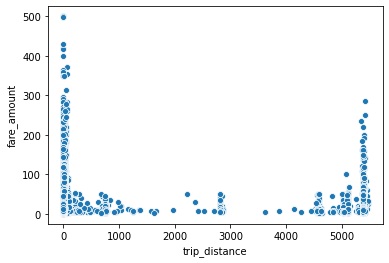

In [33]:
#Plotting of trip_distance
ax = sns.scatterplot(x="trip_distance", y="fare_amount", data=analysis_data_subset)

In [34]:
#Calculate the correlation between fare_amount and the trip_distance
print("The correlation between fare_amount and latitude_traversed is %.2f"% analysis_data_subset["trip_distance"].corr(analysis_data_subset["fare_amount"]))

The correlation between fare_amount and latitude_traversed is 0.03


There is a very strong correlation between the trip_distance and the fare_amount.

Another interesting point to note is that a number of trips appear to have a value of 0 for trip_distance, but a non-zero value for the fare_amount. These may be either errors or round trips, whereby there was a trip to a certain stop followed by a trip to the original pickup point. As there is no information on the journey that took place to achieve this round trip (including the time taken, or location of the stops along the journey), such trips will be removed from the analysis data.

In [0]:
#Removal of any trips with zero trip_distance
analysis_data_subset = analysis_data_subset[analysis_data_subset['trip_distance']>0]

### 2.3.4 Trips To/From Airports & Application of Fare Information

As can be seen by the previous plots (the pickup location map shown for your reference below) of the pickup and dropoff locations of the trips, a number of trips appear to be at / near to one of the three major airports near / in New York City:

- John F. Kennedy International Airport ("JFK"), situated to the South-East of the map
- LaGuardia Airport ("LG"), situated to the North-East of the map
- Newark Liberty International Airport ("NLI"), situated to the west of the map

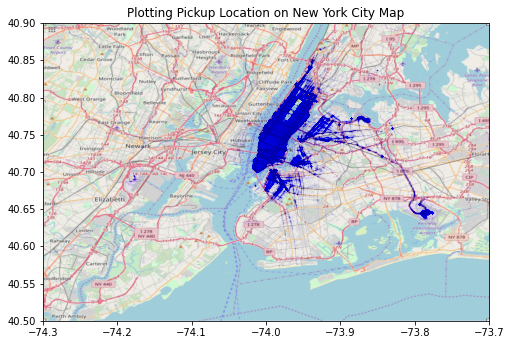

In [36]:
#Plot the pickup locations
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(analysis_data['pickup_longitude'], analysis_data['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

It would potentially be interesting to create new features based on whether a trip had pickup/dropoff at one of these airports.

One reason this may be a worthwhile process is that a trip to/from an airport may have a standard fare. To investigate this, the official website for taxi fares in NYC is considered: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

The page outlines a number of salient points related to taxi fare amounts, including the following:

- Taxi fares have a 2.50 initial charge
  - Therefore, we should exclude any trips from our analysis data which include a fare_amount of < 2.50 as these are errors
  - When predicting the fare_amount, a lower bound of 2.50 should be applied

- Trips to and from LaGuardia Airport (LGA) are charged the standard metered fare

- Trips between Manhattan and John F. Kennedy Airport (JFK) in either direction have a standard fare of 52, plus the following:
  - 0.50 MTA State Surcharge
  - 0.30 Improvement Surcharge
  - 4.50 rush hour surcharge (4pm to 8pm weekdays, excluding legal holidays)
  - New York State Congestion Surcharge of 2.50 (Yellow Taxi) or 2.75 (Green Taxi and FHV) or 0.75 (any shared ride) for all trips that begin, end or pass through Manhatan south of 96th Street
  - Plus tips and any tolls

Therefore, when predicting the fare_amount, a lower bound of 52 should be applied for any trips to/from JFK.

- Trips to Newark Airport are charged the standard metered fair plus:
  - 17.50 Newark Surcharge
  - 0.30 Improvement Surcharge
  - Plus tips and tolls

Therefore, when predicting the fare_amount, a lower bound of 20.30 (i.e. 2.50 initial charge + 17.50 + 0.30) should be applied for any trips to/from NWI.


To achieve the above standardising of airport fares, the following new features need to be created, all of which are used to assess which of the standardising bounds needs to be applied.
- manhat_pickup
- manhat_dropoff
- jfk_pickup
- jfk_dropoff
- jfk_to_manhat
- lg_pickup
- lg_dropoff
- nli_pickup
- nli_dropoff

### 2.3.4.1 Manhattan



In [0]:
#Create bounding box around Manhattan
manhat_bb = [-74.0221, -73.9267, 40.6996, 40.8336]

#Create a new feature that shows 1 if the pickup location was in the bounding box for Manhattan, and 1 if not
analysis_data_subset["manhat_pickup"] = np.where(((analysis_data_subset["pickup_longitude"] >= manhat_bb[0]) & (analysis_data_subset["pickup_longitude"] <= manhat_bb[1]) & (analysis_data_subset["pickup_latitude"] >= manhat_bb[2]) & (analysis_data_subset["pickup_latitude"] <= manhat_bb[3])), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for Manhattan, and 1 if not
analysis_data_subset["manhat_dropoff"] = np.where(((analysis_data_subset["dropoff_longitude"] >= manhat_bb[0]) & (analysis_data_subset["dropoff_longitude"] <= manhat_bb[1]) & (analysis_data_subset["dropoff_latitude"] >= manhat_bb[2]) & (analysis_data_subset["dropoff_latitude"] <= manhat_bb[3])), 1,0)

In [38]:
#Check proportion of trips with a Manhattan pickup
proportion_of_trips_manhat_pickup = analysis_data_subset["manhat_pickup"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a Manhattan pickup is  %.2f"% proportion_of_trips_manhat_pickup)

The proportion of trips which have a Manhattan pickup is  0.94


In [39]:
#Check proportion of trips with a Manhattan dropoff
proportion_of_trips_manhat_dropoff = analysis_data_subset["manhat_dropoff"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a Manhattan dropoff is  %.2f"% proportion_of_trips_manhat_dropoff)

The proportion of trips which have a Manhattan dropoff is  0.91


#### 2.3.4.1 JFK

In [0]:
#Create bounding box around JFK airport
jfk_coordinates = [-73.7781, -73.7781, 40.6413, 40.6413]
jfk_bb = [-73.84, -73.72, 40.62, 40.67] #drawn by estimating an appropriate boundix box from a map around JFK

#Create a new feature that shows 1 if the pickup location was in the bounding box for JFK, and 0 if not
analysis_data_subset["jfk_pickup"] = np.where(((analysis_data_subset["pickup_longitude"] >= jfk_bb[0]) & (analysis_data_subset["pickup_longitude"] <= jfk_bb[1]) & (analysis_data_subset["pickup_latitude"] >= jfk_bb[2]) & (analysis_data_subset["pickup_latitude"] <= jfk_bb[3])), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for JFK, and 1 if not
analysis_data_subset["jfk_dropoff"] = np.where(((analysis_data_subset["dropoff_longitude"] >= jfk_bb[0]) & (analysis_data_subset["dropoff_longitude"] <= jfk_bb[1]) & (analysis_data_subset["dropoff_latitude"] >= jfk_bb[2]) & (analysis_data_subset["dropoff_latitude"] <= jfk_bb[3])), 1,0)

#Check how many trips have a jfk pickup and how many do not
analysis_data_subset["jfk_pickup"].value_counts()

#Check how many trips have a jfk dropoff and how many do not
analysis_data_subset["jfk_dropoff"].value_counts()

#Create a new feature that shows 1 if the dropoff location was in the bounding box for Manhattan and the pickup location was in the bounding box for JFK, and 0 if not
analysis_data_subset["jfk_to_manhat"] = np.where(((analysis_data_subset["manhat_pickup"]==1) & (analysis_data_subset["jfk_dropoff"]==1)), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for JFK and the pickup location was in the bounding box for Manhat, and 0 if not
analysis_data_subset["manhat_to_jfk"] = np.where(((analysis_data_subset["jfk_pickup"]==1) & (analysis_data_subset["manhat_dropoff"]==1)), 1,0)

In [41]:
#Check proportion of trips with a JFK pickup
proportion_of_trips_jfk_pickup = analysis_data_subset["jfk_pickup"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a JFK pickup is  %.3f"% proportion_of_trips_jfk_pickup)

The proportion of trips which have a JFK pickup is  0.015


In [42]:
#Check proportion of trips with a JFK dropoff
proportion_of_trips_jfk_dropoff = analysis_data_subset["jfk_dropoff"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a JFK dropoff is  %.3f"% proportion_of_trips_jfk_dropoff)

The proportion of trips which have a JFK dropoff is  0.008


In [43]:
#Check proportion of trips with that go JFK to Manhattan
proportion_of_trips_jfk_to_manhat = analysis_data_subset["jfk_to_manhat"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which go JFK to Manhattan is  %.3f"% proportion_of_trips_jfk_to_manhat)

The proportion of trips which go JFK to Manhattan is  0.006


In [44]:
#Check proportion of trips with that go Manhattan to JFK
proportion_of_trips_manhat_to_jfk = analysis_data_subset["manhat_to_jfk"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which go Manhattan to JFK is  %.3f"% proportion_of_trips_manhat_to_jfk)

The proportion of trips which go Manhattan to JFK is  0.009


It would also be interesting to plot the trips that have a pickup / dropoff location of JFK.

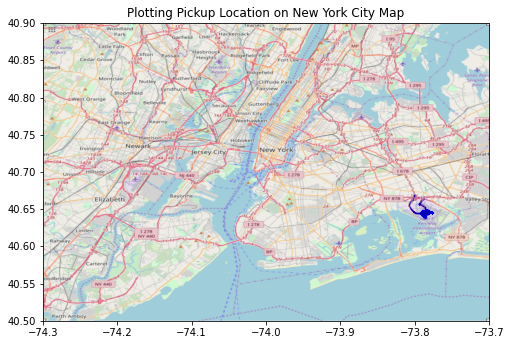

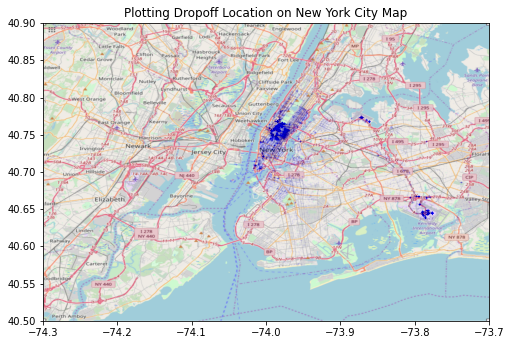

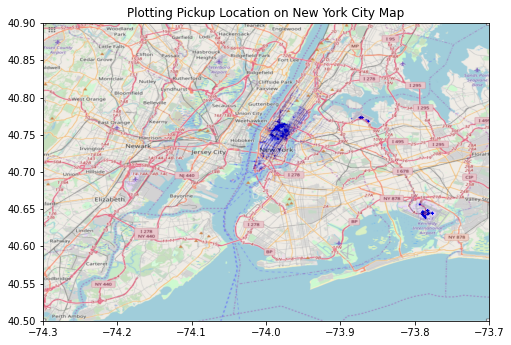

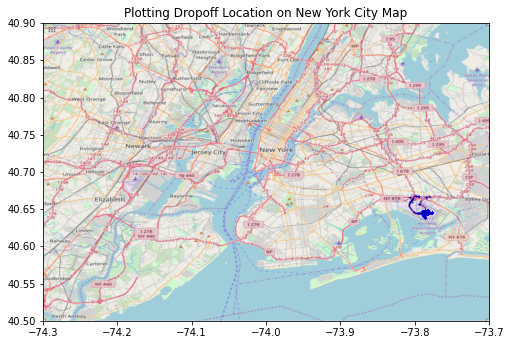

In [45]:
#Create a new dataframe with only the JFK pickup trips
jfk_pickups = analysis_data_subset.loc[analysis_data_subset["jfk_pickup"]==1]

#Create a new dataframe with only the JFK pickup trips
jfk_dropoffs = analysis_data_subset.loc[analysis_data_subset["jfk_dropoff"]==1]


#Plot the pickup locations for the JFP pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(jfk_pickups['pickup_longitude'], jfk_pickups['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the dropoff locations for the JFP pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(jfk_pickups['dropoff_longitude'], jfk_pickups['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')


#Plot the pickup locations for the JFP pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(jfk_dropoffs['pickup_longitude'], jfk_dropoffs['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the dropoff locations for the JFP pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(jfk_dropoffs['dropoff_longitude'], jfk_dropoffs['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#### 2.3.4.2 LaGuardia Airport

A similar analysis is conducted for LaGuardia Airport.

In [0]:
#Create bounding box around LaGuardia airport
lg_coordinates = [-73.8740, -73.8740, 40.7769, 40.7769]
lg_bb = [-73.90, -73.85, 40.76, 40.79] #drawn by estimating an appropriate bounding box from a map around LG airport

#Create a new feature that shows 1 if the pickup location was in the bounding box for Laguardia, and 1 if not
analysis_data_subset["lg_pickup"] = np.where(((analysis_data_subset["pickup_longitude"] >= lg_bb[0]) & (analysis_data_subset["pickup_longitude"] <= lg_bb[1]) & (analysis_data_subset["pickup_latitude"] >= lg_bb[2]) & (analysis_data_subset["pickup_latitude"] <= lg_bb[3])), 1,0)

#Create a new feature that shows 1 if the pickup location was in the bounding box for Laguardia, and 1 if not
analysis_data_subset["lg_dropoff"] = np.where(((analysis_data_subset["dropoff_longitude"] >= lg_bb[0]) & (analysis_data_subset["dropoff_longitude"] <= lg_bb[1]) & (analysis_data_subset["dropoff_latitude"] >= lg_bb[2]) & (analysis_data_subset["dropoff_latitude"] <= lg_bb[3])), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for Manhattan and the pickup location was in the bounding box for LaGuardia, and 0 if not
analysis_data_subset["lg_to_manhat"] = np.where(((analysis_data_subset["manhat_pickup"]==1) & (analysis_data_subset["lg_dropoff"]==1)), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for LaGuardia and the pickup location was in the bounding box for Manhat, and 0 if not
analysis_data_subset["manhat_to_lg"] = np.where(((analysis_data_subset["lg_pickup"]==1) & (analysis_data_subset["manhat_dropoff"]==1)), 1,0)

In [47]:
#Check proportion of trips with a LG pickup
proportion_of_trips_lg_pickup = analysis_data_subset["lg_pickup"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a LG pickup is  %.3f"% proportion_of_trips_lg_pickup)

The proportion of trips which have a LG pickup is  0.020


In [364]:
#Check proportion of trips with a LG dropoff
proportion_of_trips_lg_dropoff = analysis_data_subset["lg_dropoff"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a LG dropoff is  %.3f"% proportion_of_trips_lg_dropoff)

The proportion of trips which have a LG dropoff is  0.013


In [365]:
#Check proportion of trips with that go LG to Manhattan
proportion_of_trips_lg_to_manhat = analysis_data_subset["lg_to_manhat"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which go LG to Manhattan is  %.3f"% proportion_of_trips_lg_to_manhat)

The proportion of trips which go LG to Manhattan is  0.012


In [48]:
#Check proportion of trips with that go Manhattan to LG
proportion_of_trips_manhat_to_lg = analysis_data_subset["manhat_to_lg"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which go Manhattan to LG is  %.3f"% proportion_of_trips_manhat_to_lg)

The proportion of trips which go Manhattan to LG is  0.015


And, plotting of the trips to / from Laguardia airport.

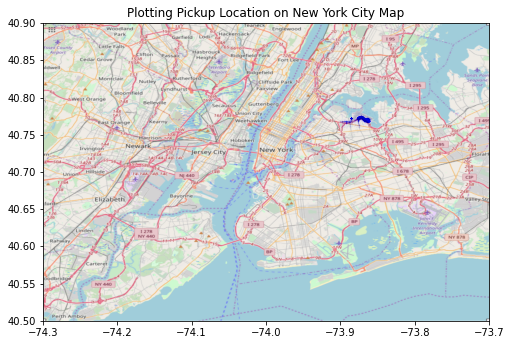

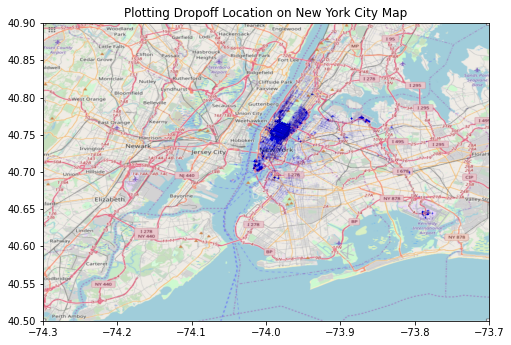

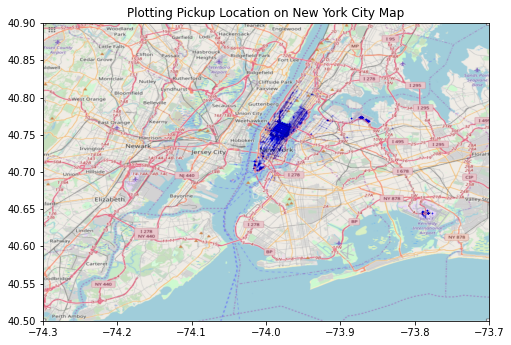

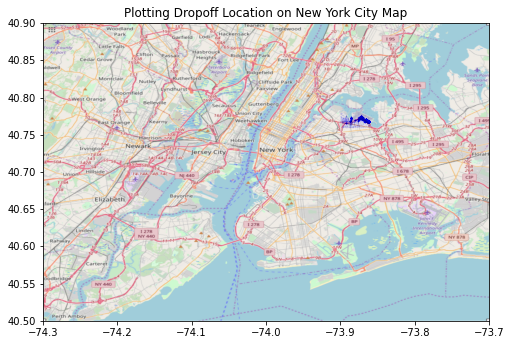

In [49]:
#Create a new dataframe with only the LG pickup trips
lg_pickups = analysis_data_subset.loc[analysis_data_subset["lg_pickup"]==1]

#Create a new dataframe with only the JFK pickup trips
lg_pickups = analysis_data_subset.loc[analysis_data_subset["lg_pickup"]==1]

#Create a new dataframe with only the JFK pickup trips
lg_dropoffs = analysis_data_subset.loc[analysis_data_subset["lg_dropoff"]==1]


#Plot the pickup locations for the LG pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(lg_pickups['pickup_longitude'], lg_pickups['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the dropoff locations for the LG pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(lg_pickups['dropoff_longitude'], lg_pickups['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')


#Plot the pickup locations for the LG dropoff trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(lg_dropoffs['pickup_longitude'], lg_dropoffs['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the dropoff locations for the LG dropoff trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(lg_dropoffs['dropoff_longitude'], lg_dropoffs['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

##### 2.3.4.3 Newark Airport

Finally, an equivalent analysis for Newark Airport.

In [0]:
#Create bounding box around Newark airport
nli_coordinates = [-74.1745, -74.1745, 40.6895, 40.6895]
nli_bb = [-74.22, -74.12, 40.65, 40.74] #drawn by estimating an appropriate boundix box from a map around NLI.

#Create a new feature that shows 1 if the pickup location was in the bounding box for NLI, and 1 if not
analysis_data_subset["nli_pickup"] = np.where(((analysis_data_subset["pickup_longitude"] >= nli_bb[0]) & (analysis_data_subset["pickup_longitude"] <= nli_bb[1]) & (analysis_data_subset["pickup_latitude"] >= nli_bb[2]) & (analysis_data_subset["pickup_latitude"] <= nli_bb[3])), 1,0)

#Create a new feature that shows 1 if the pickup location was in the bounding box for NLI, and 1 if not
analysis_data_subset["nli_dropoff"] = np.where(((analysis_data_subset["dropoff_longitude"] >= nli_bb[0]) & (analysis_data_subset["dropoff_longitude"] <= nli_bb[1]) & (analysis_data_subset["dropoff_latitude"] >= nli_bb[2]) & (analysis_data_subset["dropoff_latitude"] <= nli_bb[3])), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for Manhattan and the pickup location was in the bounding box for Newark, and 0 if not
analysis_data_subset["nli_to_manhat"] = np.where(((analysis_data_subset["manhat_pickup"]==1) & (analysis_data_subset["nli_dropoff"]==1)), 1,0)

#Create a new feature that shows 1 if the dropoff location was in the bounding box for Newark and the pickup location was in the bounding box for Manhat, and 0 if not
analysis_data_subset["manhat_to_nli"] = np.where(((analysis_data_subset["nli_pickup"]==1) & (analysis_data_subset["manhat_dropoff"]==1)), 1,0)

In [51]:
#Check proportion of trips with a NLI pickup
proportion_of_trips_nli_pickup = analysis_data_subset["nli_pickup"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a NLI pickup is  %.3f"% proportion_of_trips_nli_pickup)

The proportion of trips which have a NLI pickup is  0.000


In [52]:
#Check proportion of trips with a NLI dropoff
proportion_of_trips_nli_dropoff = analysis_data_subset["nli_dropoff"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which have a NLI dropoff is  %.3f"% proportion_of_trips_nli_dropoff)

The proportion of trips which have a NLI dropoff is  0.001


In [53]:
#Check proportion of trips with that go NLI to Manhattan
proportion_of_trips_nli_to_manhat = analysis_data_subset["nli_to_manhat"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which go NLI to Manhattan is  %.3f"% proportion_of_trips_nli_to_manhat)

The proportion of trips which go NLI to Manhattan is  0.001


In [54]:
#Check proportion of trips with that go Manhattan to NLI
proportion_of_trips_manhat_to_nli = analysis_data_subset["manhat_to_nli"].isin([1]).sum() / len(analysis_data_subset)
print("The proportion of trips which go Manhattan to NLI is  %.3f"% proportion_of_trips_manhat_to_nli)

The proportion of trips which go Manhattan to NLI is  0.000


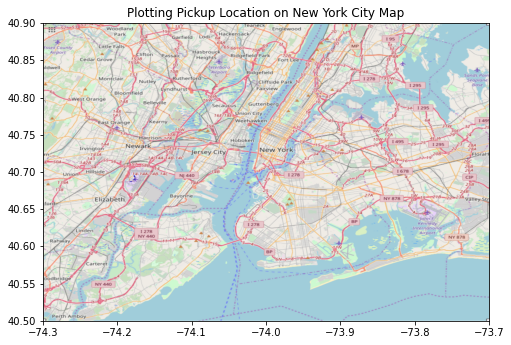

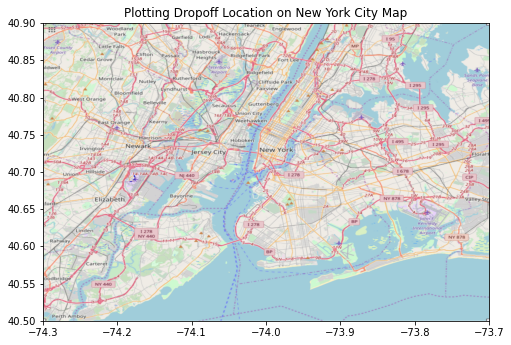

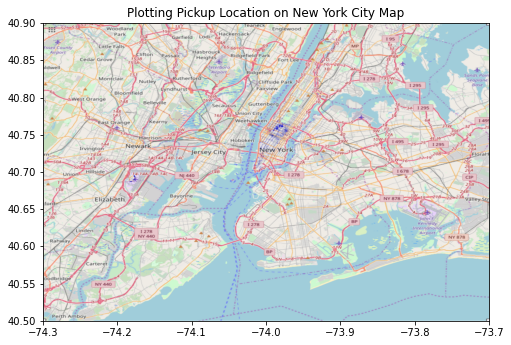

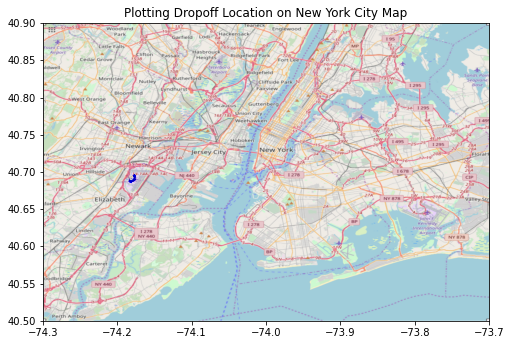

In [55]:
#Create a new dataframe with only the NLI pickup trips
nli_pickups = analysis_data_subset.loc[analysis_data_subset["nli_pickup"]==1]

#Create a new dataframe with only the NLI pickup trips
nli_dropoffs = analysis_data_subset.loc[analysis_data_subset["nli_dropoff"]==1]

#Plot the pickup locations for the NLI pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(nli_pickups['pickup_longitude'], nli_pickups['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the dropoff locations for the NLI pickup trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(nli_pickups['dropoff_longitude'], nli_pickups['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')


#Plot the pickup locations for the NLI dropoff trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(nli_dropoffs['pickup_longitude'], nli_dropoffs['pickup_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Pickup Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

#Plot the dropoff locations for the NLI dropoff trips
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(nli_dropoffs['dropoff_longitude'], nli_dropoffs['dropoff_latitude'], zorder=1, alpha= 0.01, c='b', s=1)
ax.set_title('Plotting Dropoff Location on New York City Map')
ax.set_xlim(BB_small[0],BB_small[1])
ax.set_ylim(BB_small[2],BB_small[3])
ax.imshow(nyc_map_small, zorder=0, extent = BB_small, aspect= 'equal')

In [56]:
analysis_data_subset.head()

key  fare_amount  ... nli_to_manhat  manhat_to_nli
0    2011-01-06 09:50:45.0000002         12.1  ...             0              0
1   2010-07-07 14:52:00.00000044          5.3  ...             0              0
2  2009-01-09 16:10:00.000000170         31.9  ...             0              0
3   2013-09-07 03:17:00.00000014          7.5  ...             0              0
4   2012-01-02 14:54:00.00000078          4.9  ...             0              0

[5 rows x 29 columns]

## 2.5 Encoding, Standardisation & Scaling of Data

### 2.5.1 Encoding Categorical Features
One-hot encoding is to be used to prepare the categorical features for application of Machine Learning Algorithms.

In [57]:
#Define what the categorical features to be encoded are
categorical_features = ["pickup_weekday", "pickup_hour", "pickup_month", "pickup_year"]

#One-Hot Encoding of the categorical features
categorical_features_encoded_analysis_data_subset = pd.get_dummies(analysis_data_subset[categorical_features].astype(str))
categorical_features_encoded_analysis_data_subset.head()

pickup_weekday_Friday  ...  pickup_year_2015
0                      0  ...                 0
1                      0  ...                 0
2                      1  ...                 0
3                      0  ...                 0
4                      0  ...                 0

[5 rows x 50 columns]

### 2.4.2 Standardisation of Numerical Features
Numerical features are standardised before the application of the Machine Learning Algorithms.

In [58]:
#List the numerical features
numerical_features = ["fare_amount","passenger_count", "longitude_traversed", "latitude_traversed", "trip_distance", "manhat_pickup", "manhat_dropoff","jfk_pickup", "jfk_dropoff", "jfk_to_manhat", "manhat_to_jfk", "lg_pickup", "lg_dropoff", "lg_to_manhat", "manhat_to_lg", "nli_pickup", "nli_dropoff", "nli_to_manhat", "manhat_to_nli"]

#Extract which are the numerical features, by takibng the categorical features from the original dataframe
numerical_features_analysis_data_subset = analysis_data_subset[numerical_features]

#Initiate the StandardScaler
ss = StandardScaler()

#Produce an array of the standardised numerical data
scaled_numerical_features_analysis_data_subset_array = ss.fit_transform(numerical_features_analysis_data_subset)

#Convert the arary of the standardised numerical data to a dataframe
scaled_numerical_features_analysis_data_subset = pd.DataFrame(scaled_numerical_features_analysis_data_subset_array, numerical_features_analysis_data_subset.index, numerical_features_analysis_data_subset.columns)

#Produce version without fare_amount
scaled_numerical_features_analysis_data_subset_without_fare_amount = scaled_numerical_features_analysis_data_subset.drop(['fare_amount'], axis=1)

scaled_numerical_features_analysis_data_subset.head()

fare_amount  passenger_count  ...  nli_to_manhat  manhat_to_nli
0     0.078900        -0.523375  ...      -0.035799      -0.001612
1    -0.624826        -0.523375  ...      -0.035799      -0.001612
2     2.127985         1.005716  ...      -0.035799      -0.001612
3    -0.397150        -0.523375  ...      -0.035799      -0.001612
4    -0.666221        -0.523375  ...      -0.035799      -0.001612

[5 rows x 19 columns]

## 2.6 Final Preprocessing Steps

The algorithm being used is XGBoost (which automatically selects the most relevant features) therefore there is no need to select features ourselves.

In [0]:
#Concatenate categorical and numerical data, remembering to not include the fare_amount in the data
processed_analysis_data_subset = np.concatenate([categorical_features_encoded_analysis_data_subset, scaled_numerical_features_analysis_data_subset_without_fare_amount], axis=1)

In [0]:
#Defining independent and target variables
processed_analysis_data_subset_X = processed_analysis_data_subset
processed_analysis_data_subset_y = analysis_data_subset['fare_amount']

#Splitting the data into train and test
processed_analysis_data_subset_X_train, processed_analysis_data_subset_X_test, processed_analysis_data_subset_y_train, processed_analysis_data_subset_y_test = train_test_split(processed_analysis_data_subset_X, processed_analysis_data_subset_y, test_size = 0.3, random_state=42)

# 3. Application of Machine Learning Algorithms

## 3.1 Application to Training Data

The XGBoost algorithm is fitted to the data, and used to predict the values of fare_amount.

As the test statistic used in the competition is Root Mean Square Error, this is also calculated.

In [61]:
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(seed=123, objective="reg:linear", n_estimators=50)

# Fit the regressor to the training set
xg_reg.fit(processed_analysis_data_subset_X_train, processed_analysis_data_subset_y_train)

[19:41:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [62]:
# Predict the labels of the test set: preds
predictions_xg = xg_reg.predict(processed_analysis_data_subset_X_test)

#Convert my predictions to a DataFrame
evaluation_of_predictions_xg = pd.DataFrame(predictions_xg,columns=['Predictions'])

#Convert both the predictions and the actual values to an array to be used in Python mean-squared error functiopn from scikitlearn
a1_xg = np.asarray(evaluation_of_predictions_xg)
a2_xg = np.asarray(processed_analysis_data_subset_y_test)

#Evaluate the Root Mean Square Error of the predictions against the actual values
rmse_xg = sqrt(mean_squared_error(a2_xg, a1_xg))
rmse_xg

4.323748869499417

At this point the fare_amount have been predicted for the analysis data, with a RMSE of c. 4.0.

An additional step is to apply the previously discussed constraints related to minimum fare amount (2.50) and constraints on the fare_amount for journeys related to airports. This is achieved by concatenating the dataframe containing the X_test data, the y_test data, and the predicted fare_amount - the constraints are then applied to the predictions.



Monday 25th May

we have the original X_test dataframe, the y_test dataframe, and predictions y

Concat them back together, then create a real_world prediction column which overrides the prediction

In [0]:
#Create list of numerical features excluding the fare_amount
numerical_features_without_fare_amount = [n for n in numerical_features if n !='fare_amount']

#Create dataframe of the X_test data
post_prediction_analysis_data_subset_columns = categorical_features_encoded_analysis_data_subset.columns.tolist() + numerical_features_without_fare_amount
post_prediction_analysis_data_subset = pd.DataFrame(processed_analysis_data_subset_X_test,columns=post_prediction_analysis_data_subset_columns)

#Convert the y_test fare_amounts to a list, and adds them as a feature in the DataFrame to the correct trip
post_prediction_analysis_data_subset['fare_amount'] = processed_analysis_data_subset_y_test.dropna().tolist()

#Add the prediction previously found as a feature to this dataframe
post_prediction_analysis_data_subset['prediction'] = predictions_xg

In [64]:
#Apply the constraint of the initial 2.50 charge
initial_charge = 2.50
post_prediction_analysis_data_subset['prediction_adj']=np.where(post_prediction_analysis_data_subset['prediction']<initial_charge, initial_charge, post_prediction_analysis_data_subset['prediction'])

#Add in the constraint for trips from JFK to Manhattan
jfk_manhat_min_fare = 52.8
post_prediction_analysis_data_subset['prediction_adj']=np.where((post_prediction_analysis_data_subset['jfk_to_manhat']>0)&(post_prediction_analysis_data_subset['prediction']<=jfk_manhat_min_fare),jfk_manhat_min_fare,post_prediction_analysis_data_subset['prediction'])

#Add in the constraint for trips from Manhattan to JFK
post_prediction_analysis_data_subset['prediction_adj']=np.where((post_prediction_analysis_data_subset['manhat_to_jfk']>0)&(post_prediction_analysis_data_subset['prediction']<=jfk_manhat_min_fare),jfk_manhat_min_fare,post_prediction_analysis_data_subset['prediction'])

#Add in the constraint  for trips from Newark to Manhattan
nli_manhat_min_fare = 17.5
post_prediction_analysis_data_subset['prediction_adj']=np.where((post_prediction_analysis_data_subset['nli_to_manhat']>0)&(post_prediction_analysis_data_subset['prediction']<=nli_manhat_min_fare),nli_manhat_min_fare,post_prediction_analysis_data_subset['prediction'])

#Add in the constraint  for trips from Manhattan to Newark
post_prediction_analysis_data_subset['prediction_adj']=np.where((post_prediction_analysis_data_subset['manhat_to_nli']>0)&(post_prediction_analysis_data_subset['prediction']<=nli_manhat_min_fare),nli_manhat_min_fare,post_prediction_analysis_data_subset['prediction'])


#Create new feature of the adjustments made
post_prediction_analysis_data_subset['adj'] = post_prediction_analysis_data_subset['prediction_adj'] - post_prediction_analysis_data_subset['prediction']

post_prediction_analysis_data_subset.head()

pickup_weekday_Friday  pickup_weekday_Monday  ...  prediction_adj  adj
0                    0.0                    0.0  ...       22.579031  0.0
1                    0.0                    0.0  ...       31.467876  0.0
2                    0.0                    1.0  ...       11.540476  0.0
3                    0.0                    0.0  ...        7.353610  0.0
4                    0.0                    0.0  ...       24.055195  0.0

[5 rows x 72 columns]

In [65]:
#Check the number of trips for which an adjustment was made to the predicted fare
print(len(post_prediction_analysis_data_subset.loc[post_prediction_analysis_data_subset['adj']!=0]))

0


It appears that no such adjustments were made.

## 3.2 Application to Test Data

Moving onto application of the algorithm to the test data.

# 3.2.1 Pre-processing of submission data
Before the algorithm is applied, the equivalent pre-processing steps must be taken.

In [66]:
#Check for missing values
missing_data = submission_data.isnull().sum()
missing_data.head()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dtype: int64

Again, there is no missing data so the subsequent processing steps are applied.

In [0]:
#Creation of new features
submission_data['pickup_datetime'] = pd.to_datetime(submission_data['key'])

#Extract day of week of pickup
submission_data["pickup_weekday"] = submission_data["pickup_datetime"].dt.day_name()

#Extract hour of day of pickup
submission_data["pickup_hour"] = submission_data["pickup_datetime"].dt.hour

#Extract month of year of pickup
submission_data["pickup_month"] = submission_data["pickup_datetime"].dt.month

#Extract year of pickup
submission_data["pickup_year"] = submission_data["pickup_datetime"].dt.year

#Longitude traversed
submission_data["longitude_traversed"] = submission_data["dropoff_longitude"] - submission_data["pickup_longitude"]

#Latitude traversed
submission_data["latitude_traversed"] = submission_data["dropoff_latitude"] - submission_data["pickup_latitude"]

#Haversine distance travelled
submission_data["trip_distance"] = haversine(submission_data["pickup_longitude"], submission_data["pickup_latitude"], submission_data["dropoff_longitude"], submission_data["dropoff_latitude"])


#Manhattan pickup
submission_data["manhat_pickup"] = np.where(((submission_data["pickup_longitude"] >= manhat_bb[0]) & (submission_data["pickup_longitude"] <= manhat_bb[1]) & (submission_data["pickup_latitude"] >= manhat_bb[2]) & (submission_data["pickup_latitude"] <= manhat_bb[3])), 1,0)

#Manhattan dropoff
submission_data["manhat_dropoff"] = np.where(((submission_data["dropoff_longitude"] >= manhat_bb[0]) & (submission_data["dropoff_longitude"] <= manhat_bb[1]) & (submission_data["dropoff_latitude"] >= manhat_bb[2]) & (submission_data["dropoff_latitude"] <= manhat_bb[3])), 1,0)

#JFK pickup
submission_data["jfk_pickup"] = np.where(((submission_data["pickup_longitude"] >= jfk_bb[0]) & (submission_data["pickup_longitude"] <= jfk_bb[1]) & (submission_data["pickup_latitude"] >= jfk_bb[2]) & (submission_data["pickup_latitude"] <= jfk_bb[3])), 1,0)

#JFK dropoff
submission_data["jfk_dropoff"] = np.where(((submission_data["dropoff_longitude"] >= jfk_bb[0]) & (submission_data["dropoff_longitude"] <= jfk_bb[1]) & (submission_data["dropoff_latitude"] >= jfk_bb[2]) & (submission_data["dropoff_latitude"] <= jfk_bb[3])), 1,0)

#JFK to Manhat
submission_data["jfk_to_manhat"] = np.where(((submission_data["manhat_pickup"]==1) & (submission_data["jfk_dropoff"]==1)), 1,0)

#Manhat to JFK
submission_data["manhat_to_jfk"] = np.where(((submission_data["jfk_pickup"]==1) & (submission_data["manhat_dropoff"]==1)), 1,0)


#LG pickup
submission_data["lg_pickup"] = np.where(((submission_data["pickup_longitude"] >= lg_bb[0]) & (submission_data["pickup_longitude"] <= lg_bb[1]) & (submission_data["pickup_latitude"] >= lg_bb[2]) & (submission_data["pickup_latitude"] <= lg_bb[3])), 1,0)

#LG dropoff
submission_data["lg_dropoff"] = np.where(((submission_data["dropoff_longitude"] >= lg_bb[0]) & (submission_data["dropoff_longitude"] <= lg_bb[1]) & (submission_data["dropoff_latitude"] >= lg_bb[2]) & (submission_data["dropoff_latitude"] <= lg_bb[3])), 1,0)

#LG to Manhat
submission_data["lg_to_manhat"] = np.where(((submission_data["manhat_pickup"]==1) & (submission_data["lg_dropoff"]==1)), 1,0)

#Manhat to LG
submission_data["manhat_to_lg"] = np.where(((submission_data["lg_pickup"]==1) & (submission_data["manhat_dropoff"]==1)), 1,0)

#NLI pickup
submission_data["nli_pickup"] = np.where(((submission_data["pickup_longitude"] >= nli_bb[0]) & (submission_data["pickup_longitude"] <= nli_bb[1]) & (submission_data["pickup_latitude"] >= nli_bb[2]) & (submission_data["pickup_latitude"] <= nli_bb[3])), 1,0)

#NLI dropoff
submission_data["nli_dropoff"] = np.where(((submission_data["dropoff_longitude"] >= nli_bb[0]) & (submission_data["dropoff_longitude"] <= nli_bb[1]) & (submission_data["dropoff_latitude"] >= nli_bb[2]) & (submission_data["dropoff_latitude"] <= nli_bb[3])), 1,0)

#NLI to Manhat
submission_data["nli_to_manhat"] = np.where(((submission_data["manhat_pickup"]==1) & (submission_data["nli_dropoff"]==1)), 1,0)

#Manhat to NLI
submission_data["manhat_to_nli"] = np.where(((submission_data["nli_pickup"]==1) & (submission_data["manhat_dropoff"]==1)), 1,0)


#Encoding of categorical features
categorical_features_encoded_submission_data = pd.get_dummies(submission_data[categorical_features].astype(str))
categorical_features_encoded_submission_data.head()


#Standardisation of numerical features
#Extract which are the numerical features, by takibng the categorical features from the original dataframe
submission_data_numerical_features = ["passenger_count", "longitude_traversed", "latitude_traversed", "trip_distance", "manhat_pickup", "manhat_dropoff","jfk_pickup", "jfk_dropoff", "jfk_to_manhat", "manhat_to_jfk", "lg_pickup", "lg_dropoff", "lg_to_manhat", "manhat_to_lg", "nli_pickup", "nli_dropoff", "nli_to_manhat", "manhat_to_nli"]
numerical_features_submission_data = submission_data[submission_data_numerical_features]


#Import the StandardScaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

#Produce an array of the standardised numerical data
scaled_numerical_features_submission_data_array = ss.fit_transform(numerical_features_submission_data)

#Convert the arary of the standardised numerical data to a dataframe
scaled_numerical_features_submission_data = pd.DataFrame(scaled_numerical_features_submission_data_array, numerical_features_submission_data.index, numerical_features_submission_data.columns)


#Concatenate categorical and numerical data
processed_submission_data = np.concatenate([categorical_features_encoded_submission_data, scaled_numerical_features_submission_data], axis=1)


#Defining independent variables
processed_submission_data_X = processed_submission_data

In [68]:
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(seed=123, objective="reg:linear", n_estimators=50)

# Fit the regressor to the training set
xg_reg.fit(processed_analysis_data_subset_X, processed_analysis_data_subset_y)

# Predict the labels of the test set: preds
preds_xg = xg_reg.predict(processed_submission_data_X)

#Transformation of the predictions into a dataframe
submission_predictions_xg = pd.DataFrame(preds_xg,columns=['fare_amount'])
submission_predictions_xg['key'] = submission_data['key']
cols_xg = ['key', 'fare_amount']
submission_predictions_xg = submission_predictions_xg[cols_xg]

[19:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Then adjustments are applied for the constraints as previous (related to e.g. airport journey standard fare)

In [69]:
#Create dataframe of the X_test data
post_prediction_submission_data_columns = post_prediction_analysis_data_subset_columns
post_prediction_submission_data = pd.DataFrame(processed_submission_data_X,columns=post_prediction_submission_data_columns)

#Add the prediction previously found as a feature to this dataframe
post_prediction_submission_data['prediction'] = preds_xg

#Apply the constraint of the initial 2.50 charge
post_prediction_submission_data['prediction_adj']=np.where(post_prediction_submission_data['prediction']<initial_charge, initial_charge, post_prediction_submission_data['prediction'])

#Add in the constraint for trips from JFK to Manhattan
post_prediction_submission_data['prediction_adj']=np.where((post_prediction_submission_data['jfk_to_manhat']>0)&(post_prediction_submission_data['prediction']<=jfk_manhat_min_fare),jfk_manhat_min_fare,post_prediction_submission_data['prediction'])

#Add in the constraint  for trips from Manhattan to JFK
post_prediction_submission_data['prediction_adj']=np.where((post_prediction_submission_data['manhat_to_jfk']>0)&(post_prediction_submission_data['prediction']<=jfk_manhat_min_fare),jfk_manhat_min_fare,post_prediction_submission_data['prediction'])

#Add in the constraint  for trips from Newark to Manhattan
post_prediction_submission_data['prediction_adj']=np.where((post_prediction_submission_data['nli_to_manhat']>0)&(post_prediction_submission_data['prediction']<=nli_manhat_min_fare),nli_manhat_min_fare,post_prediction_submission_data['prediction'])

#Make adjustments for trips from Manhattan to Newark
post_prediction_submission_data['prediction_adj']=np.where((post_prediction_submission_data['manhat_to_nli']>0)&(post_prediction_submission_data['prediction']<=nli_manhat_min_fare),nli_manhat_min_fare,post_prediction_submission_data['prediction'])

#Create new feature of the adjustments made
post_prediction_submission_data['adj'] = post_prediction_submission_data['prediction_adj'] - post_prediction_submission_data['prediction']

post_prediction_submission_data.head()


pickup_weekday_Friday  pickup_weekday_Monday  ...  prediction_adj  adj
0                    0.0                    0.0  ...       14.364327  0.0
1                    0.0                    0.0  ...       21.001879  0.0
2                    0.0                    0.0  ...       22.716040  0.0
3                    0.0                    0.0  ...       13.608159  0.0
4                    0.0                    0.0  ...       38.568840  0.0

[5 rows x 71 columns]

In [0]:
#Create the submission file with predictions which take into account the additional constraints
post_real_world_predictions = post_prediction_submission_data['prediction_adj']
submission_predictions_adj = pd.DataFrame(post_real_world_predictions.values,columns=['fare_amount'])
submission_predictions_adj['key'] = submission_data['key']
cols_adj = ['key', 'fare_amount']
submission_predictions_adj = submission_predictions_adj[cols_xg]

#Conversion of the predictions dataframe into a CSV file for submission
submission_predictions_adj.to_csv('taxi_predictions_adj.csv', index=False)

The CSV file was uploaded to the submission page on the Kaggle website, and achieved an RMSE of 3.89233, placing me in the top 60% of scores - a steady improvement on my previous Kaggle entries.

# 4. Conclusions and Next Steps

Whilst it is encouraging to continue to improve my performance, there are some areas of my work that I would look to improve on and apply to my next projects:

- My analysis was slightly limited by only samplying 5% of the data. In future, where possible, I would look to analyse of the data to ensure I had the full picture of the data and trained my model as completely as possible

- I would look to conduct parameter tuning in future projects to ensure I am maximising the efficiency and accuracy of the algorithm

- There were also some areas that were specific to this project that I can use as learning points in future work. e.g. an interesting next step would be to transform the location data into coordinates on a rotated grid. This would help in areas such as defining the box to encompass Manhattan (and Manhattan alone). A method for achieving this would of course also be applicable to other projects considering location data.

